# Analysis of $\Delta\Delta$G of 11ntR$\cdot$GAAA variants compared to their frequency in natural RNAs.
Copyright 2023 John Shin under GPL-3.0

Figure 6A-C come from this document.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from scipy import stats

from matplotlib.colors import Normalize as Norm
import networkx as nx
from tqdm import tqdm

In [2]:
def ztransform(x,verbose=False):
    mean = np.mean(x)
    std = np.std(x)
    if verbose:
        print('Mean',mean)
        print('Std',std)
    return (x-mean)/std

def RSquared(x,y,beta):
    ybar = np.mean(y)
    yhat = x*beta[0]+beta[1]
    return 1 - np.sum((y-yhat)**2)/np.sum((y-ybar)**2)

In [3]:
data_path='Data/'

In [4]:
found_11ntRs = pd.read_excel(data_path+'freq_data.xlsx',header=0)[['sequence','Total']].rename(
    columns={'Total':'GNRA_confirmed'})
found_11ntRs.head()

,sequence,GNRA_confirmed
0,UAUGG_CCUAAG,154
1,CAUGG_CCUAAA,80
2,UAUGA_UCUAAG,67
3,UAUGC_GCUAAG,65
4,UAUGG_CCUAAC,42


In [5]:
prior_ddGs = pd.read_csv('data/prior_ddGs.csv').rename(columns={'Unnamed: 0':'sequence'}).set_index('sequence')

temp = (prior_ddGs[[col for col in prior_ddGs.columns if '30mM_Mg_GAAA' in col]] - \
    prior_ddGs.loc['UAUGG_CCUAAG',[col for col in prior_ddGs.columns if '30mM_Mg_GAAA' in col]].values).mean(axis=1)

temp.name='ddG'

found_11ntRs['log_one_plus_abundance'] = np.log10(1+found_11ntRs['GNRA_confirmed'])

found_11ntRs = found_11ntRs.merge(temp,
    left_on = 'sequence',right_index=True,how='left')

found_11ntRs.head()

,sequence,GNRA_confirmed,log_one_plus_abundance,ddG
0,UAUGG_CCUAAG,154,2.190332,0.000000
1,CAUGG_CCUAAA,80,1.908485,-0.246469
2,UAUGA_UCUAAG,67,1.832509,0.592151
3,UAUGC_GCUAAG,65,1.819544,0.787813
4,UAUGG_CCUAAC,42,1.633468,0.328227


In [6]:
ddG_GAAA = pd.read_csv(data_path+'ddGs/avg_ddG_GAAA.csv',index_col=0)
ddG_GAAA['limit'] = ddG_GAAA['limit'].astype(bool)
ddG_GAAA.loc['UAUGG_CCUAAG','ddG'] = 0
ddG_GAAA.loc['UAUGG_CCUAAG','limit'] = False

ddG_GAAA.head()

,first_loc,first_res,second_loc,second_res,ddG,ddG_lb,ddG_ub,limit
UAUGG_CCUAAG,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False
AAUGG_CCUAAG,7.0,A,NaN,NaN,2.269253,1.848655,2.441301,False
CAUGG_CCUAAG,7.0,C,NaN,NaN,2.317993,2.111339,2.492009,False
GAUGG_CCUAAG,7.0,G,NaN,NaN,0.306750,-0.175082,0.483862,False
UAAGG_CCUAAG,9.0,A,NaN,NaN,1.440634,1.088564,1.618814,False


In [7]:
# def plotLimits(data,x,y,ax,query,color,size):
    
#     ax.scatter(data.query('(not limit) and '+query,engine='python')[x],
#                data.query('(not limit) and '+query,engine='python')[y],
#                color=color,s=size,alpha=0.8)
#     ax.scatter(data.query('(limit) and '+query,engine='python')[x],
#                data.query('(limit) and '+query,engine='python')[y],
#                color=color,s=size,alpha=0.2)
    
#     return None    

# def plotLimits2(data,x,y,ax,query,hue,size,palette='viridis'):
    
#     ax.scatter(data.query('(not limit) and '+query,engine='python')[x]+\
#                np.clip(np.random.randn(len(data.query('(not limit) and '+query,engine='python')))*0.1,-.5,.5),
#                data.query('(not limit) and '+query,engine='python')[y],
#                c=data.query('(not limit) and '+query,engine='python')[hue],
#                s=size,lw=size/10,
#                cmap = palette,vmin=-0.5,vmax=5)
#     h = ax.scatter(data.query('(limit) and '+query,engine='python')[x]+\
#                np.clip(np.random.randn(len(data.query('(limit) and '+query,engine='python')))*0.1,-.5,.5),
#                data.query('(limit) and '+query,engine='python')[y],
#                c=data.query('(limit) and '+query,engine='python')[hue],
#                s=size,lw=size/10,facecolor='none',
#                cmap = palette,vmin=-0.5,vmax=5)
#     h.set_edgecolors(h.get_facecolors())
#     h.set_facecolor('none')
    
#     return None    

In [8]:
freq_ddG_df = found_11ntRs[['sequence','GNRA_confirmed']].merge(
     ddG_GAAA,
     how='right',
     right_index=True,left_on='sequence',suffixes=('','_r'))
freq_ddG_df['GNRA_confirmed'] = freq_ddG_df['GNRA_confirmed'].fillna(0)
freq_ddG_df['natural'] = freq_ddG_df['GNRA_confirmed'] > 0 
freq_ddG_df = freq_ddG_df.set_index('sequence')
freq_ddG_df['log_one_plus_abundance'] = np.log10(1+freq_ddG_df['GNRA_confirmed'])
freq_ddG_df

,GNRA_confirmed,first_loc,first_res,second_loc,second_res,ddG,ddG_lb,ddG_ub,limit,natural,log_one_plus_abundance
sequence,,,,,,,,,,,
UAUGG_CCUAAG,154.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,True,2.190332
AAUGG_CCUAAG,0.0,7.0,A,NaN,NaN,2.269253,1.848655,2.441301,False,False,0.000000
CAUGG_CCUAAG,0.0,7.0,C,NaN,NaN,2.317993,2.111339,2.492009,False,False,0.000000
GAUGG_CCUAAG,1.0,7.0,G,NaN,NaN,0.306750,-0.175082,0.483862,False,True,0.301030
UAAGG_CCUAAG,3.0,9.0,A,NaN,NaN,1.440634,1.088564,1.618814,False,True,0.602060
...,...,...,...,...,...,...,...,...,...,...,...
UUUGG_CUUAAG,0.0,8.0,U,2.0,U,4.481618,4.145518,4.613270,True,False,0.000000
UUUGG_GCUAAG,0.0,8.0,U,1.0,G,4.481618,4.145518,4.613270,True,False,0.000000
UUUGG_UCUAAG,0.0,8.0,U,1.0,U,4.481618,4.145518,4.613270,True,False,0.000000


In [9]:
temp = (prior_ddGs[[col for col in prior_ddGs.columns if '5Mg150K_GAAA' in col]] - \
    prior_ddGs.loc['UAUGG_CCUAAG',[col for col in prior_ddGs.columns if '5Mg150K_GAAA' in col]].values).mean(axis=1)

temp.name='ddG_5mM_Mg_150_mM_K'


freq_ddG_df = freq_ddG_df.merge(temp,
    left_on = 'sequence',right_index=True,how='left')

In [10]:
def linFit(df,condition):
    '''Fit to Equation 11 in the text and return fit parameters and the z-transformed residuals of the fit'''
    
    x = df[df['GNRA_confirmed']>0][condition]
    y = df[df['GNRA_confirmed']>0]['log_one_plus_abundance']
    
    beta = np.polyfit(x,y,1)
    
    return beta,ztransform(df['log_one_plus_abundance']-np.clip(beta[1] + beta[0] * df[condition],0,np.inf),
                          verbose=True)

In [11]:
beta, z_scores = linFit(freq_ddG_df,'ddG')
beta_5mM_Mg_150mM_K, z_scores_5mM_Mg_150mM_K = linFit(freq_ddG_df,'ddG_5mM_Mg_150_mM_K')

Mean -0.06852141565488877
Std 0.2209349204043152
Mean -0.11090998258299674
Std 0.23577606731794448


In [12]:
sigma = stats.norm.ppf(0.05/529) # Bonferroni-corrected significance threshold of 0.5

In [13]:
significant = set(z_scores.loc[z_scores<sigma].index)
significant_5mM_Mg_150mM_K = set(z_scores_5mM_Mg_150mM_K.loc[z_scores_5mM_Mg_150mM_K<sigma].index)

significant_any = significant|significant_5mM_Mg_150mM_K

In [14]:
x = freq_ddG_df['ddG']
y = freq_ddG_df['log_one_plus_abundance']

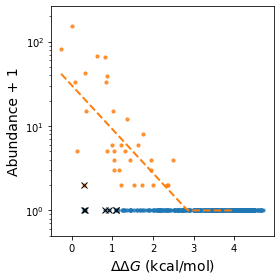

In [15]:
fig,ax = plt.subplots(figsize=(4,4))

ax.plot(freq_ddG_df.loc[significant,'ddG'],
        freq_ddG_df.loc[significant,'GNRA_confirmed']+1,
        'kx',zorder=10)

ax.scatter(freq_ddG_df[freq_ddG_df['GNRA_confirmed']==0]['ddG'],
           freq_ddG_df[freq_ddG_df['GNRA_confirmed']==0]['GNRA_confirmed']+1,
           s=10,alpha= 0.8,c='tab:blue')
ax.scatter(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG'],
           freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['GNRA_confirmed']+1,
           s=10,alpha= 0.8,c='tab:orange')



x_range = np.linspace(min(x),4)
ax.plot(x_range,10**(np.clip(beta[1] + beta[0] * x_range,0,np.inf)),'--',
        color='tab:orange',linewidth=2)

ax.set_ylim((.5,ax.get_ylim()[1]+100))

ax.set_yscale('log')


ax.set_xlabel(r'$\Delta\Delta G$ (kcal/mol)',fontsize=14)
ax.set_ylabel('Abundance + 1',fontsize=14)


corr = np.corrcoef(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG'],
            np.log10(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['GNRA_confirmed']+1))[1][0]

R2 = RSquared(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG'],
              np.log10(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['GNRA_confirmed']+1),
              beta)


plt.tight_layout()

plt.savefig('Figures/abundance_vs_ddG_found_linfit.svg',facecolor='white',dpi=600)

plt.show()

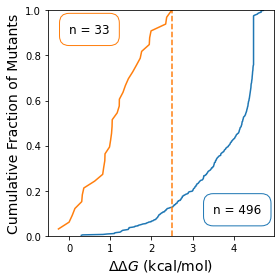

In [16]:
fig,ax = plt.subplots(figsize=(4,4))#,facecolor='white',dpi=600)

ax.plot(freq_ddG_df[freq_ddG_df['GNRA_confirmed']==0].sort_values('ddG')['ddG'],
           np.cumsum(np.ones(sum(freq_ddG_df['GNRA_confirmed']==0)))/496,
           color='tab:blue')
ax.plot(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0].sort_values('ddG')['ddG'],
           np.cumsum(np.ones(sum(freq_ddG_df['GNRA_confirmed']>0)))/33,
           color='tab:orange')


ax.set_xlabel(r'$\Delta\Delta G$ (kcal/mol)',fontsize=14)

ax.set_ylabel('Cumulative Fraction of Mutants',fontsize=14)

max_ddG = max(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG'])
percent_above_threshold = sum((freq_ddG_df['GNRA_confirmed']==0) & (freq_ddG_df['ddG']>max_ddG))/\
                            sum(freq_ddG_df['GNRA_confirmed']==0)*100

ax.set_ylim((0,1))

ax.axvline(max_ddG,color='tab:orange',linestyle='--')

ax.text(0,.9,
        f"n = {sum(freq_ddG_df['GNRA_confirmed']>0)}",
        fontsize=12,linespacing=1.5,
        bbox={'boxstyle':'round','facecolor':'white','pad':.8,'edgecolor':'tab:orange'})
ax.text(3.5,.1,
        f"n = {sum(freq_ddG_df['GNRA_confirmed']==0)}",
        fontsize=12,linespacing=1.5,
        bbox={'boxstyle':'round','facecolor':'white','pad':.8,'edgecolor':'tab:blue'})

plt.tight_layout()

plt.savefig('Figures/cumulative_vs_ddG.svg',facecolor='white',dpi=600)

plt.show()

__Supplemental Figure__

In [17]:
# fig,ax = plt.subplots(figsize=(4,4))

# ax.plot(freq_ddG_df.loc[significant_5mM_Mg_150mM_K,'ddG_5mM_Mg_150_mM_K'],
#         freq_ddG_df.loc[significant_5mM_Mg_150mM_K,'GNRA_confirmed']+1,
#         'kx',zorder=10)

# ax.scatter(freq_ddG_df[freq_ddG_df['GNRA_confirmed']==0]['ddG_5mM_Mg_150_mM_K'],
#            freq_ddG_df[freq_ddG_df['GNRA_confirmed']==0]['GNRA_confirmed']+1,
#            s=10,alpha= 0.8,c='tab:blue')
# ax.scatter(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG_5mM_Mg_150_mM_K'],
#            freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['GNRA_confirmed']+1,
#            s=10,alpha= 0.8,c='tab:red')



# x_range = np.linspace(min(x),4)
# ax.plot(x_range,10**(np.clip(beta_5mM_Mg_150mM_K[1] + beta_5mM_Mg_150mM_K[0] * x_range,0,np.inf)),'--',
#         color='tab:red',linewidth=2)

# ax.set_ylim((.5,ax.get_ylim()[1]+100))

# ax.set_yscale('log')


# ax.set_xlabel(r'$\Delta\Delta G$ (kcal/mol)',fontsize=14)
# ax.set_ylabel('Abundance + 1',fontsize=14)


# corr = np.corrcoef(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG_5mM_Mg_150_mM_K'],
#             np.log10(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['GNRA_confirmed']+1))[1][0]

# R2 = RSquared(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG_5mM_Mg_150_mM_K'],
#               np.log10(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['GNRA_confirmed']+1),
#               beta_5mM_Mg_150mM_K)


# plt.tight_layout()

# plt.savefig('Figures/Supplement/abundance_vs_ddG_found_linfit_5_mM_Mg_150_mM_K.png',facecolor='white',dpi=600)
# plt.show()

In [18]:
# fig,ax = plt.subplots(figsize=(4,4))

# ax.plot(freq_ddG_df[freq_ddG_df['GNRA_confirmed']==0].sort_values('ddG_5mM_Mg_150_mM_K')['ddG_5mM_Mg_150_mM_K'],
#            np.cumsum(np.ones(sum(freq_ddG_df['GNRA_confirmed']==0))/496),
#            color='tab:blue')
# ax.plot(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0].sort_values('ddG_5mM_Mg_150_mM_K')['ddG_5mM_Mg_150_mM_K'],
#            np.cumsum(np.ones(sum(freq_ddG_df['GNRA_confirmed']>0))/33),
#            color='tab:red')


# ax.set_xlabel(r'$\Delta\Delta G$ (kcal/mol)',fontsize=14)

# ax.set_ylabel('Cumulative Fraction of Mutants',fontsize=14)

# max_ddG = max(freq_ddG_df[freq_ddG_df['GNRA_confirmed']>0]['ddG_5mM_Mg_150_mM_K'])
# percent_above_threshold = sum((freq_ddG_df['GNRA_confirmed']==0) & (freq_ddG_df['ddG_5mM_Mg_150_mM_K']>max_ddG))/\
#                             sum(freq_ddG_df['GNRA_confirmed']==0)*100

# ax.axvline(max_ddG,color='tab:red',linestyle='--')

# ax.set_ylim((0,1))

# ax.text(0.5,.9,
#         f"n = {sum(freq_ddG_df['GNRA_confirmed']>0)}",
#         fontsize=12,linespacing=1.5,
#         bbox={'boxstyle':'round','facecolor':'white','pad':.8,'edgecolor':'tab:red'})
# ax.text(4.5,.1,
#         f"n = {sum(freq_ddG_df['GNRA_confirmed']==0)}",
#         fontsize=12,linespacing=1.5,
#         bbox={'boxstyle':'round','facecolor':'white','pad':.8,'edgecolor':'tab:blue'})

# plt.tight_layout()
# plt.savefig('Figures/Supplement/cumulative_vs_ddG_5_mM_Mg_150_mM_K.png',facecolor='white',dpi=600)


# plt.show()

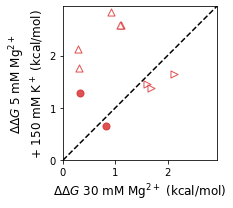

In [19]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter(freq_ddG_df.loc[significant&significant_5mM_Mg_150mM_K,'ddG'],
           freq_ddG_df.loc[significant&significant_5mM_Mg_150mM_K,'ddG_5mM_Mg_150_mM_K'],
           color='tab:red',
           label='Significant in both',s=50,
          alpha=0.8)
ax.scatter(freq_ddG_df.loc[significant-significant_5mM_Mg_150mM_K,'ddG'],
           freq_ddG_df.loc[significant-significant_5mM_Mg_150mM_K,'ddG_5mM_Mg_150_mM_K'],
           color='white',edgecolor='tab:red',linewidth=1,marker='^',
           label='Significant in\n30 mM Mg',s=50,
          alpha=0.8)
ax.scatter(freq_ddG_df.loc[significant_5mM_Mg_150mM_K-significant,'ddG'],
           freq_ddG_df.loc[significant_5mM_Mg_150mM_K-significant,'ddG_5mM_Mg_150_mM_K'],
           color='white',edgecolor='tab:red',linewidth=1,marker='>',
           label='Significant in\n5 mM Mg + 150 mM K',s=50,
          alpha=0.8)

ax.set_aspect(1)

lims = (0,max(ax.get_ylim()[1],ax.get_xlim()[1]))

ax.plot(lims,lims,'k--')

ax.set_ylim(lims)
ax.set_xlim(lims)

ax.set_yticks(np.arange(3))
ax.set_xticks(np.arange(3))

ax.set_xlabel(r'$\Delta\Delta G$ 30 mM Mg$^{2+}$ (kcal/mol)',fontsize=12)
ax.set_ylabel(r'$\Delta\Delta G$ 5 mM Mg$^{2+}$'+'\n'+'+ 150 mM K$^+$ (kcal/mol)',fontsize=12)

plt.tight_layout()
plt.savefig('Figures/ddG_shift_5_mM_Mg_150_mM_K.svg',facecolor='white',dpi=600)

plt.show()


In [20]:
# freq_ddG_df.loc[significant_any].join(pd.DataFrame(
#     {
#         'Significance 30 mM':z_scores.loc[significant_any],
#         'Signifiance 5 mM 150 mM':z_scores_5mM_Mg_150mM_K.loc[significant_any]
#     },index=significant_any
# )).to_csv('Figures/Underrepresented_11ntRs.csv')

In [21]:
# temp_idx = set(z_scores.loc[z_scores>-sigma].index)|set(z_scores_5mM_Mg_150mM_K.loc[z_scores_5mM_Mg_150mM_K>-sigma].index)


# freq_ddG_df.loc[temp_idx].join(pd.DataFrame(
#     {
#         'Significance 30 mM':z_scores.loc[temp_idx],
#         'Signifiance 5 mM 150 mM':z_scores_5mM_Mg_150mM_K.loc[temp_idx]
#     },index=temp_idx
# )).to_csv('Figures/Overrepresented_11ntRs.csv')